# 内积注意力

如果我们的 `query` 和 `key` 都是一样长度的。例如他们的长度都是 $d$，也就是 $q,k \in \mathbb{R}^{d}$，那么 $a(\mathbf{q}, \mathbf{k}_i)$ 可以被写为下面的式子：

$$
a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}
$$

也就是没有可以学习的参数。这里 $\sqrt{d}$ 会使得对向量长度是影响不大。

In [11]:
import math
import torch
from torch import nn
from torch.nn import functional as F

from lib.d2l_torch import masked_softmax, show_heatmaps

## 内积注意力例子

-  batch size 为 2，对于每一个 batch，有：
- - 两个 `query`，每个的长度为 $2$
- 有 $10$ 个 `key-value pair`
- - 其中 `key` 的长度为 $2$（这里 `key` 的长度和 `query` 的长度是一样的）；
- - 其中 `value` 的长度为 $4$；

In [2]:
queries, keys = torch.normal(0, 1, (2, 2, 2)), torch.ones((2, 10, 2))
# The two value matrices in the values minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
# 打印大小, 第一位都是 batch size
print(queries.shape, keys.shape, values.shape)

torch.Size([2, 2, 2]) torch.Size([2, 10, 2]) torch.Size([2, 10, 4])


In [5]:
# 计算 q*k/d 的值
# (2*2, 2*10) --> (2, 10)
# torch.bmm 按照 batch 进行计算
d = queries.shape[-1]
scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
print(scores.shape)
print(scores[0][0])

torch.Size([2, 2, 10])
tensor([-0.6989, -0.6989, -0.6989, -0.6989, -0.6989, -0.6989, -0.6989, -0.6989,
        -0.6989, -0.6989])


In [9]:
# 对 score 进行 softmax
attention_weight = F.softmax(scores, dim=2)
print(attention_weight[0][0])

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


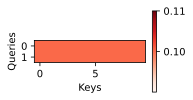

In [14]:
show_heatmaps(
    matrices=[[attention_weight[0]]],
    xlabel='Keys',
    ylabel='Queries'
) # 所有的权重都是一样的

## 内积注意力

In [6]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention. (这里是没有参数的)
    """
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads  # To be covered later

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None, window_mask=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        if window_mask is not None:  # To be covered later
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            # Shape of window_mask: (num_windows, no. of queries, no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [7]:
queries, keys = torch.normal(0, 1, (2, 1, 2)), torch.ones((2, 10, 2))
# The two value matrices in the values minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6]) # 第一个查看前 2 个, 第二个查看前 6 个

attention = DotProductAttention(dropout=0.5)
attention.eval()
print(attention(queries, keys, values, valid_lens))

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
